### Potential things to change:
Train/test split <br>
activation function <br>
The way in which we evaluate the loss (currently using MSE, but could use something else) <br>
Optimal learning rate and iterations. <br>
General check over. The original framework and code is based on a binary problem, this is regression, need to check things are correct for regression. <br>
Check derivatives are correct. <br>


In [293]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


california_housing = fetch_california_housing(as_frame=True)

In [294]:
# Converting into a pandas dataframe
df_features = california_housing.data

# TO REMOVE CERTAIN FEATURES
# Keepinng just the latitude and longitude.
# df_features = df_features.iloc[:, 6:]

df_targets = california_housing.target

In [295]:
df_features.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22


In [296]:
df_targets.head(2)

0    4.526
1    3.585
Name: MedHouseVal, dtype: float64

In [297]:
# Standardising the features. NEEDS CHECKING
X = df_features.values
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [298]:
# Checking for missing values in the features  
df_features.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [299]:
# Checking for missing values in the features
df_targets.isnull().sum()

0

In [300]:
# Turning the data into a numpy array
# X = df_features.to_numpy()
y = df_targets.to_numpy().reshape(-1, 1)
print(X.shape)
print(y.shape)

(20640, 8)
(20640, 1)


## Train/Test Split

In [301]:
# 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14448, 8)
(14448, 1)
(6192, 8)
(6192, 1)


## Helper Functions

Sigmoid was used in the workshop, however this was a binary classification problem. Here we are trying to predict house prices and so our output doesnt want to be in the range (0,1). So we use ReLu instead, which is another common activation function. It is defined as f(z) = max(0, z). 

In [302]:
# Activation function
def relu(z):
    return np.maximum(0, z)

# Derivative of the activation function (relu)
def drelu(a):
    return (a > 0).astype(float)

# Root mean squared error loss function
# We times by 0.5 to make the mse derivative simpler.
#  
def mse_loss(y_pred, y_true, n):
    # Root mean squared error (scalar)
    return 0.5*np.mean((y_pred - y_true)**2)

# Used for setting the random seed for reproducibility
def set_seed(seed=0):
    np.random.seed(seed)

def plot_loss_curve(losses, title="Loss curve"):
    plt.figure(figsize=(6,4))
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()


## Forward Propagation

Using 1 hidden layers of k neurons (variable -> num_hidden_neurons) (choice was arbitrary), and an output layer of 1 neuron (median price prediction).

In [303]:
X_train.shape[1]

8

In [304]:
num_hidden_neurons = 32

In [305]:
# Example of the weights and biases. Used for checking first iteration is working correctly.

# Capitals implies that its a matrix (), lowercase is a vector.
W1 = 0.5*np.random.rand(X_train.shape[1], num_hidden_neurons)
# Note, in the worksheet, times by 0.5. Maybe change later?
b1 = np.zeros(num_hidden_neurons)

w2 = 0.5*np.random.rand(num_hidden_neurons, 1) # (5, 1) for w2
b2 = np.zeros(1)

In [306]:
w2.shape

(32, 1)

In [307]:
def forward(X, W1, b1, w2, b2):
    z1 = X @ W1 + b1
    # Applying activation function (relu) to the hidden layer
    a1 = relu(z1)

    z2 = a1 @ w2 + b2
    y_hat = z2 # Explain why not applying activation function to the output layer (regression problem)
    # Cache is used to store temporary values
    cache = {"z1": z1, "a1": a1, "z2": z2, "y_hat": y_hat}  
    return y_hat, cache

y_hat, cache = forward(X_train, W1, b1, w2, b2)
loss = mse_loss(y_hat, y_train, n=X_train.shape[0])

print("Predictions (y_hat):\n", np.round(y_hat, 3))
print("Loss:", loss)

Predictions (y_hat):
 [[0.982]
 [0.007]
 [0.   ]
 ...
 [0.171]
 [1.534]
 [1.579]]
Loss: 14.435749972988214


Text(0.5, 1.0, 'Distribution of predictions (y_hat)')

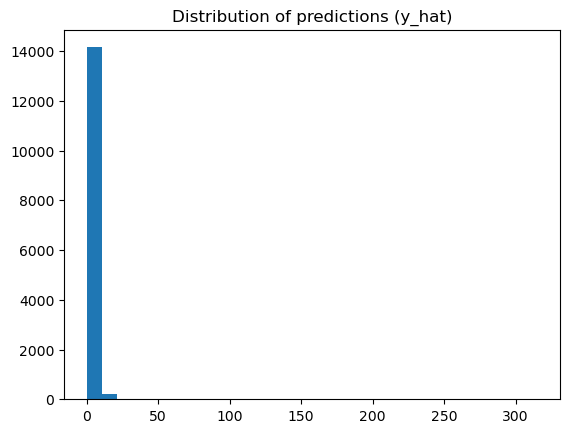

In [308]:
# Plotting due to having an issues before where the predictions were all the same. 
plt.hist(y_hat, bins=30)
plt.title("Distribution of predictions (y_hat)")

The central difference approximation to the partial derivative with respect to $x$ is (Assuming a 2 variable function):

$$
\frac{\partial f}{\partial x}(x, y)
\approx
\frac{f(x + \varepsilon, y) - f(x - \varepsilon, y)}{2\varepsilon}
$$

In [309]:
def loss_with_params(X, y, W1, b1, w2, b2):
    # "_" to ignore the cache
    y_hat, _ = forward(X, W1, b1, w2, b2)
    # Calculating the loss for the given parameters 
    return mse_loss(y_hat, y, n=X.shape[0])

# Computes an approximation of the partial derivative of the loss with respect to w2.
# This is done by using the central difference formula.
def numerical_grad_w2(X, y, W1, b1, w2, b2, eps=1e-5):
    # Return an array of zeros with the same shape as w2, used to store the numerical gradients
    grad = np.zeros_like(w2)

    # Iterating over each row of w2
    for i in range(w2.shape[0]):
        # Iterating over each column of w2
        for j in range(w2.shape[1]):

            # w2_pos and w2_neg are copies of w2 where we will add and subtract eps to the (i, j) 
            # element respectively
            w2_pos = w2.copy(); w2_neg = w2.copy()
            w2_pos[i, j] += eps
            w2_neg[i, j] -= eps

            # The result from a small step in the positive and negative w2 direction.
            # i.e the f(x + eps, y) and f(x - eps, y) notated above.
            L_pos = loss_with_params(X, y, W1, b1, w2_pos, b2)
            L_neg = loss_with_params(X, y, W1, b1, w2_neg, b2)

            # Approximated gradient for that element of w2
            grad[i, j] = (L_pos - L_neg) / (2*eps)
        # This is repeated for each w2 element.
    return grad

num_gw2 = numerical_grad_w2(X_train, y_train, W1, b1, w2, b2, eps=1e-5)
print("Numerical gradient dL/dw2:\n", np.round(num_gw2, 6))

Numerical gradient dL/dw2:
 [[3.731186]
 [2.770882]
 [3.490025]
 [2.396876]
 [1.937778]
 [2.339618]
 [2.925942]
 [3.88755 ]
 [3.297766]
 [2.348618]
 [4.068877]
 [1.509562]
 [3.266584]
 [3.324739]
 [2.990972]
 [2.577564]
 [1.307899]
 [3.852334]
 [2.296147]
 [4.189186]
 [4.448665]
 [3.924494]
 [3.249997]
 [4.665851]
 [3.87288 ]
 [3.849464]
 [3.522579]
 [1.77471 ]
 [3.762427]
 [4.50288 ]
 [2.349335]
 [4.619048]]


In [310]:
# Actual backpropagation
def backprop(X, y, W1, b1, w2, b2):
    N = X.shape[0] # No. of rows (number of samples)
    y_hat, cache = forward(X, W1, b1, w2, b2)
    a1 = cache["a1"] # Hidden layer 

    dL_dyhat = (y_hat - y) / N
    dL_dz2 = dL_dyhat  # ReLu not used on output (CHECK correct)

    dw2 = a1.T @ dL_dz2
    db2 = np.sum(dL_dz2, axis=0)

    dL_da1 = dL_dz2 @ w2.T
    dL_dz1 = dL_da1 * drelu(a1)

    dW1 = X.T @ dL_dz1
    db1 = np.sum(dL_dz1, axis=0)

    return {"dW1": dW1, "db1": db1, "dw2": dw2, "db2": db2}

grads = backprop(X_train, y_train, W1, b1, w2, b2)
print("Backprop gradient dL/dw2:\n", np.round(grads["dw2"], 6))

Backprop gradient dL/dw2:
 [[3.731186]
 [2.770882]
 [3.490025]
 [2.396876]
 [1.937778]
 [2.339618]
 [2.925942]
 [3.88755 ]
 [3.297766]
 [2.348618]
 [4.068877]
 [1.509562]
 [3.266584]
 [3.324739]
 [2.990972]
 [2.577564]
 [1.307899]
 [3.852334]
 [2.296147]
 [4.189186]
 [4.448665]
 [3.924494]
 [3.249997]
 [4.665851]
 [3.87288 ]
 [3.849464]
 [3.522579]
 [1.77471 ]
 [3.762427]
 [4.50288 ]
 [2.349335]
 [4.619048]]


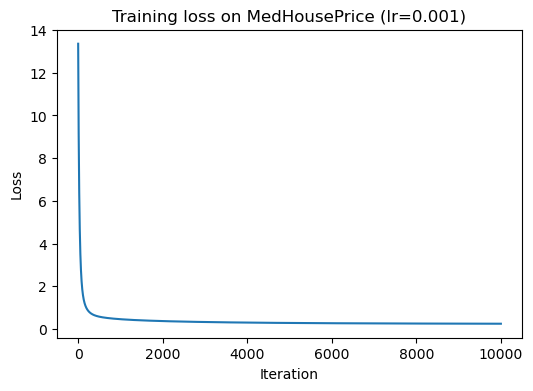

[13.357906231578019, 12.92093706753839, 12.502370722461322, 12.101293241686257, 11.71690695168013, 11.348284550556995, 10.994714089611756, 10.65546619971663, 10.329907954118273, 10.017450237665638, 9.717426960103195, 9.429254204968734, 9.152432557953121, 8.886414710609754, 8.63071857972561, 8.38489308760967, 8.148490791191142, 7.921106535291788, 7.702341955169869, 7.491811908714837, 7.289184314441672, 7.094120527667176, 6.906277238672015, 6.725340467255324, 6.551024008524059, 6.383066288206968, 6.221198348262558, 6.0651531382013015, 5.914689214169905, 5.769563601518109, 5.629569363151742, 5.494504188480692, 5.3641779151532765, 5.238410092094244, 5.117024427269503, 4.9998098308094185, 4.8866028389267715, 4.777234837598428, 4.671547981980747, 4.569414117221422, 4.470697035664178, 4.375262461689986, 4.282988988992743, 4.193744049461747, 4.10742321249015, 4.023914500377097, 3.943104282324755, 3.86488263645835, 3.7891545994915066, 3.7158272920191426, 3.644813510193039, 3.576021881616224, 3.

In [311]:
def train_NN(X, y, hidden=num_hidden_neurons, lr=1.0, iters=4000, seed=2):
    set_seed(seed)
    W1 = 0.5*np.random.randn(X.shape[1], hidden)
    b1 = np.zeros(hidden)
    w2 = 0.5*np.random.randn(hidden, 1)
    b2 = np.zeros(1)

    losses = []
    for t in range(iters):
        y_hat, _ = forward(X, W1, b1, w2, b2)
        L = mse_loss(y_hat, y, n=X.shape[0])
        losses.append(L)

        grads = backprop(X, y, W1, b1, w2, b2)
        W1 -= lr * grads["dW1"]
        b1 -= lr * grads["db1"]
        w2 -= lr * grads["dw2"]
        b2 -= lr * grads["db2"]

    return W1, b1, w2, b2, losses

lr = 0.001   # TODO: try 0.1, 0.5, 1.0, 2.0
iters = 10000

W1_t, b1_t, w2_t, b2_t, losses = train_NN(X_train, y_train, hidden=num_hidden_neurons, lr=lr, iters=iters, seed=2)
plot_loss_curve(losses, title=f"Training loss on MedHousePrice (lr={lr})")
print(losses)
y_hat, _ = forward(X_train, W1_t, b1_t, w2_t, b2_t)
print("Final predictions:", np.round(y_hat.T, 3))
print("Final loss:", losses[-1])

## Testing the model

The parameters of the model are W1_t, b1_t, W2_t, b2_t. We can use these to make predictions on the test set and evaluate the performance of the model.

In [312]:
def predict(X, W1, b1, w2, b2):
    y_hat, _ = forward(X, W1, b1, w2, b2)
    return y_hat

y_pred_test = predict(X_test, W1_t, b1_t, w2_t, b2_t)

test_loss = mse_loss(y_pred_test, y_test, n=X_test.shape[0])
print("Test loss:", test_loss)

print(y_test)
print(y_pred_test)


Test loss: 0.24569754543444694
[[0.477  ]
 [0.458  ]
 [5.00001]
 ...
 [2.184  ]
 [1.194  ]
 [2.098  ]]
[[0.66321706]
 [1.50270721]
 [2.80946933]
 ...
 [2.30267265]
 [1.44779704]
 [2.10549798]]
